In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from tqdm import tqdm


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
root_path = 'gdrive/My Drive/MS-ITU-Smester-02/DL-05/Assignment 5 Dataset'

### Loading and normalizing CIFAR10

In [5]:
#Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

#pass transform here-in
train_data = datasets.ImageFolder(root_path + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(root_path + '/test', transform=test_transforms)
validation_data = datasets.ImageFolder(root_path + '/validation', transform=test_transforms)

#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True)
validationloader = torch.utils.data.DataLoader(validation_data, batch_size=64, shuffle=True)

print("Classes: ")
class_names = train_data.classes
print(class_names)

Classes: 
['infected', 'normal']


In [0]:
wholeDataLoader = {'train':trainloader, 'val':validationloader} # for training and validation

### Training Model


In [0]:
#if you have gpu then you need to convert the network and data to cuda
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [0]:
 def plotGraph(epochs, TrainData,validationData, yLabel):
    plt.figure(figsize= (7,7) )
    plt.plot(np.arange(epochs), TrainData)
    plt.plot(np.arange(epochs), validationData)
    plt.legend(["Training " +yLabel ,"Validation " + yLabel])
    plt.xlabel("Number of Epochs")
    plt.ylabel(yLabel)

In [0]:
def drawConfusionMatrix():
  # For Validation Data
  print('F1 score:', f1_score(Y_act_val, Y_pred_val))
  matrix = confusion_matrix(Y_act_val, Y_pred_val)
  df_cm = pd.DataFrame(matrix, ['infected', 'normal'], ['infected', 'normal'])
  plt.figure(figsize=(5,4))
  sns.set(font_scale=1.4)
  sns.heatmap(df_cm, annot=True, annot_kws={"size": 13})

In [0]:
def train_model(model, criterion, optimizer, num_epochs=10):
    since = time.time()
    trainingError = []
    validationError = []
    trainingAccurcy = []
    validationAccuracy = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('==============================================================')

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            total = 0

            # Iterate over data.
            for inputs, labels in wholeDataLoader[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs.data, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                total += labels.size(0)
                running_corrects += (preds == labels).sum().item()

            epoch_loss = running_loss / total
            epoch_acc = running_corrects / total

            print('{} -- Loss: {:.4f} , Acc: {:.2f} %'.format(phase, epoch_loss, epoch_acc*100))
            
            if phase == 'train':
                trainingError.append(epoch_loss)
                trainingAccurcy.append(epoch_acc)
            else:
                validationError.append(epoch_loss)
                validationAccuracy.append(epoch_acc)

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Validation Accuracy: {:4f} %'.format(best_acc*100))

    # load best model weights
    model.load_state_dict(best_model_wts)
    #plotGraph(num_epochs,trainingError,validationError, "Loss")
    #plotGraph(num_epochs,trainingAccurcy,validationAccuracy, "Accuracy")

    return model,trainingError,validationError,trainingAccurcy,validationAccuracy

### Task 1


#### VGG-16


In [12]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)
print(vgg16)
print('Output Layer of VGG16 : ', vgg16.classifier[6].out_features) # 1000 

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

In [0]:
# Freeze all the layers except the last FC layers
for param in vgg16.parameters():
    param.requires_grad = True

In [0]:
# Making Custom Classifier
new_layers = []
new_layers.extend( [nn.Linear( vgg16.classifier[0].in_features , 7*10+100, bias=True )])
new_layers.extend( [nn.ReLU( inplace=True )])
new_layers.extend( [nn.Dropout( p=0.5, inplace=False )])
new_layers.extend( [nn.Linear( 7*10+100 , len(class_names) )])

# Modifying new layers in VGG16 architecture
vgg16.classifier = nn.Sequential(*new_layers)

In [0]:
# For Task 2 ---> Unfreezing random Convolutional Layers 
for i in [14,15,17,24,26,28]:
  for param in vgg16.features[i].parameters():
    param.requires_grad = True


In [0]:
# Unfreezing FC layers
for param in vgg16.classifier.parameters():
    param.requires_grad = True

In [16]:
# Printing modified VGG16 architecture
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
Epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.0001, momentum=0.9)
vgg16 = vgg16.to(device)

In [24]:
##### training
vgg16Model,trainingError,validationError,trainingAccurcy,validationAccuracy = train_model( vgg16, criterion, optimizer, num_epochs = 10 )

Epoch 1/10
train -- Loss: 0.0000 , Acc: 100.00 %
val -- Loss: 12.3204 , Acc: 59.00 %

Epoch 2/10
train -- Loss: 0.0000 , Acc: 100.00 %
val -- Loss: 12.3294 , Acc: 59.00 %

Epoch 3/10
train -- Loss: 0.0000 , Acc: 100.00 %
val -- Loss: 12.3318 , Acc: 59.00 %

Epoch 4/10
train -- Loss: 0.0000 , Acc: 100.00 %
val -- Loss: 12.3354 , Acc: 59.00 %

Epoch 5/10
train -- Loss: 0.0000 , Acc: 100.00 %
val -- Loss: 12.3382 , Acc: 59.00 %

Epoch 6/10
train -- Loss: 0.0000 , Acc: 100.00 %
val -- Loss: 12.3443 , Acc: 59.00 %

Epoch 7/10
train -- Loss: 0.0000 , Acc: 100.00 %
val -- Loss: 12.3494 , Acc: 59.00 %

Epoch 8/10
train -- Loss: 0.0000 , Acc: 100.00 %
val -- Loss: 12.3523 , Acc: 59.00 %

Epoch 9/10
train -- Loss: 0.0000 , Acc: 100.00 %
val -- Loss: 12.3580 , Acc: 59.00 %

Epoch 10/10
train -- Loss: 0.0000 , Acc: 100.00 %
val -- Loss: 12.3654 , Acc: 59.00 %

Training complete in 65m 24s
Best Validation Accuracy: 59.000000 %


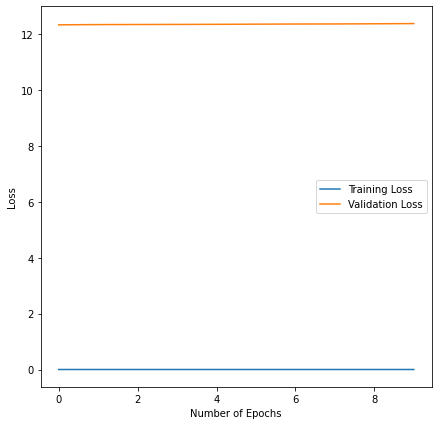

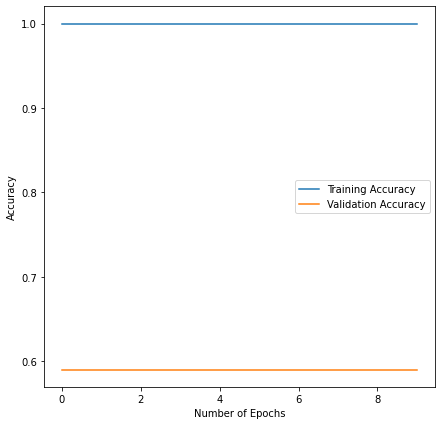

In [27]:
plotGraph(Epochs,trainingError,validationError, "Loss")
plotGraph(Epochs,trainingAccurcy,validationAccuracy, "Accuracy")


In [0]:
torch.save(vgg16Model.state_dict(), 'gdrive/My Drive/MS-ITU-Smester-02/DL-05/vgg16_FC_Only.pth')

In [0]:
## Testing Accuracy
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16Model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Testing data Accuracy: %d %%' % (100 * correct / total))

#### Resnet-18

In [33]:
# Load the pretrained model from pytorch
resnet18 = models.resnet18(pretrained=True)
print(resnet18) 

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
 

In [0]:
# Freeze all the layers except the last FC layers
for param in resnet18.parameters():
    param.requires_grad = True

In [0]:
# Making Custom Classifier
new_layers = []
new_layers.extend( [nn.Linear( vgg16.classifier[0].in_features , 7*10+100, bias=True )])
new_layers.extend( [nn.ReLU( inplace=True )])
new_layers.extend( [nn.Dropout( p=0.5, inplace=False )])
new_layers.extend( [nn.Linear( 7*10+100 , len(class_names) )])

# Modifying new layers in VGG16 architecture
resnet18.fc = nn.Sequential(*new_layers)

In [0]:
#unfreezing FC Layers
for param in resnet18.fc.parameters():
  param.requires_grad=True

In [0]:
Epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet18.parameters(), lr=0.001, momentum=0.9)

In [39]:
# Printing modified Resnet-18 architecture
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
resnet18 = resnet18.to(device)

In [0]:
##### training
resnetModel,trainingError,validationError,trainingAccurcy,validationAccuracy = train_model( resnet18, criterion, optimizer, num_epochs = 10 )

In [0]:
torch.save(resnetModel.state_dict(), root_path + 'res18_FC_Only.pth')